# 1. Imports, Options and Ingestion

In [1]:
# Imports list
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

from minisom import MiniSom

# Spectral Clustering
from scipy.spatial import distance
from gower import gower_matrix
from scipy import linalg
from sklearn.preprocessing import normalize

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.lines import Line2D
import seaborn as sns

from matplotlib import __version__ as mplver

from sklearn.impute import KNNImputer
from sklearn.metrics import root_mean_squared_error

In [2]:
# Style is importantuntitled:Untitled-1.ipynb?jupyter-notebook
sns.set(style="white")

# Ensuring pandas always prints all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 1000)

%config InlineBackend.figure_format = 'retina'

In [3]:
path = '../../data/'

In [4]:
# Reading the csv data
regulars = pd.read_csv(f'{path}rfm_regulars.csv', index_col=0)

# 2. Spectral

In [5]:
# Define the features of interest, and take a sample

n_clusters = 3
n_samples = 2000
random_state = 1
target_features = [
    'per_chain_order'
    , 'log_total_amt'
    , 'avg_amt_per_product'
    , 'n_cuisines'
    , 'cust_city_2.0', 'cust_city_4.0', 'cust_city_8.0'
]
n_features = len(target_features)

spectral_df = regulars[target_features].copy().sample(n=n_samples, random_state=random_state) 
arr_spectral_df = spectral_df.values

In [6]:
# Compute the Gower distance matrix and apply the rbf parameter

rbf_param = 3.141542 

gower_dist = gower_matrix(arr_spectral_df)

K = np.exp(-rbf_param * gower_dist)
D = K.sum(axis=1)
D = np.sqrt(1/D)
M = np.multiply(D[np.newaxis, :], np.multiply(K, D[np.newaxis, :]))

In [7]:
U, Sigma, _ = linalg.svd(M, full_matrices=False, lapack_driver='gesvd')
Usubset = U[:, :n_clusters]
y_pred_sc = KMeans(n_clusters=n_clusters).fit_predict(normalize(Usubset))

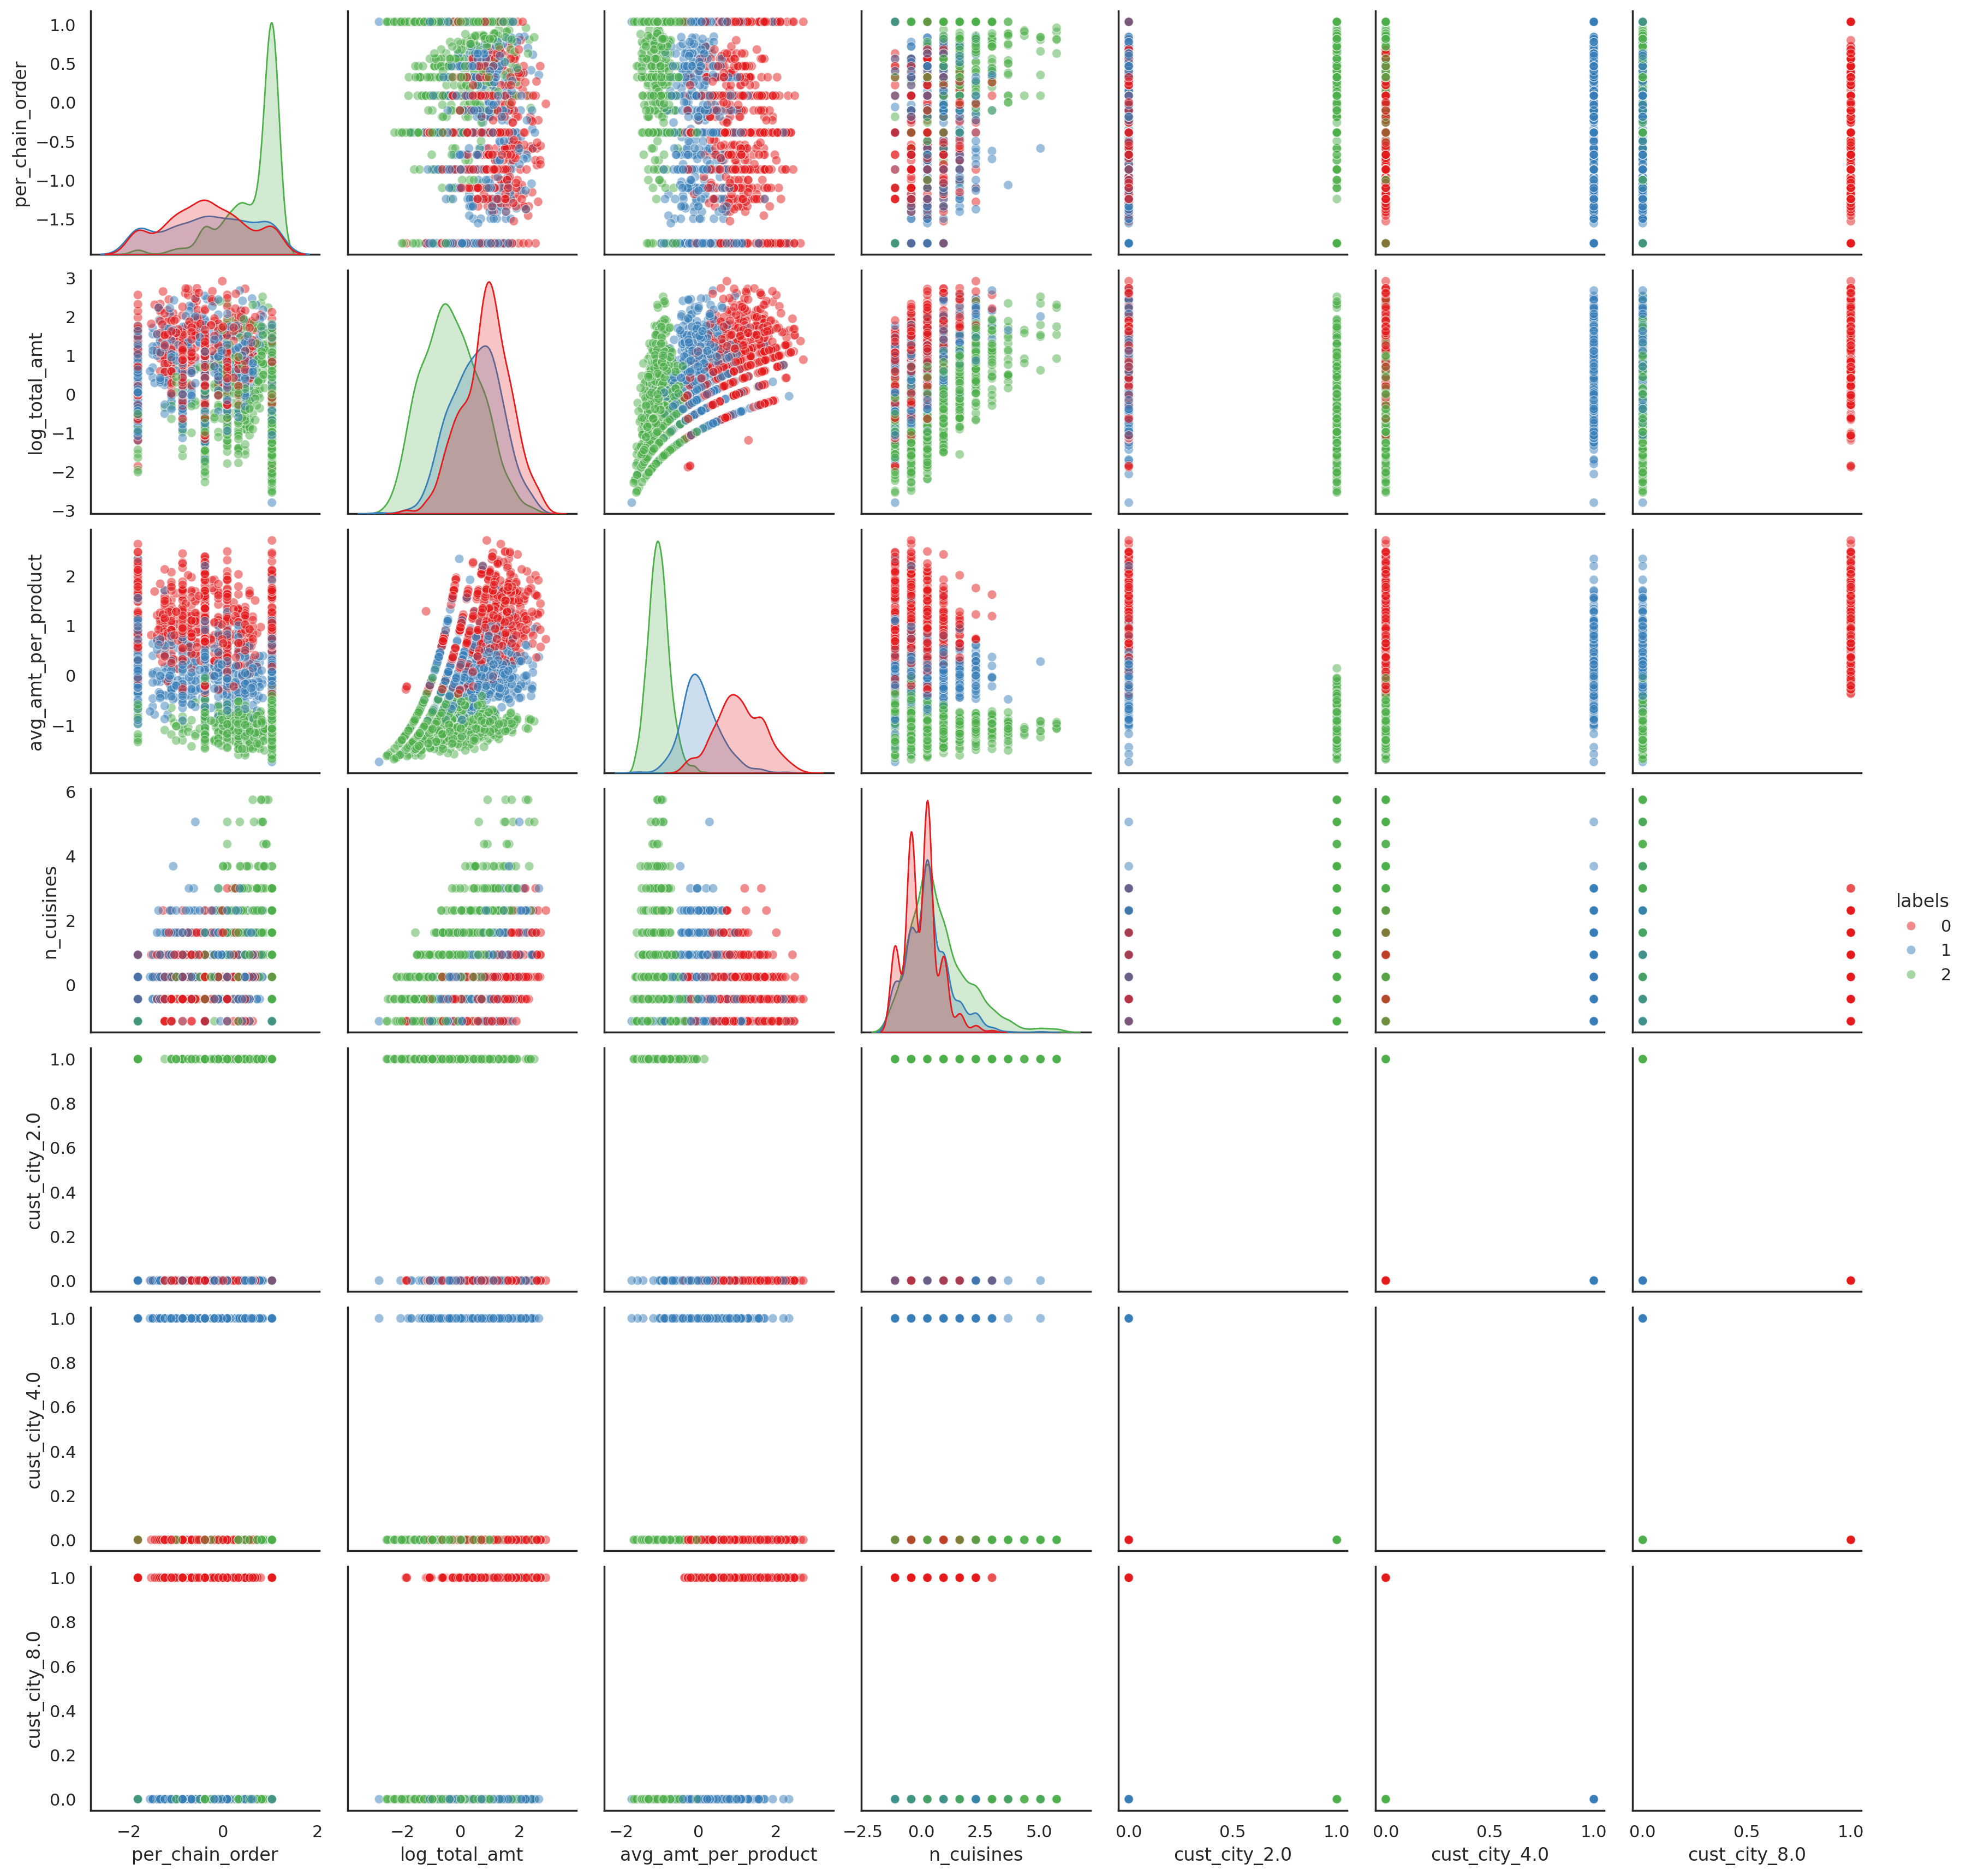

In [8]:
df = pd.DataFrame(arr_spectral_df, columns=target_features, index=spectral_df.index) 
df['labels'] = y_pred_sc  

sns.pairplot(df, hue="labels", palette="Set1", plot_kws={'alpha':.5})
plt.show()

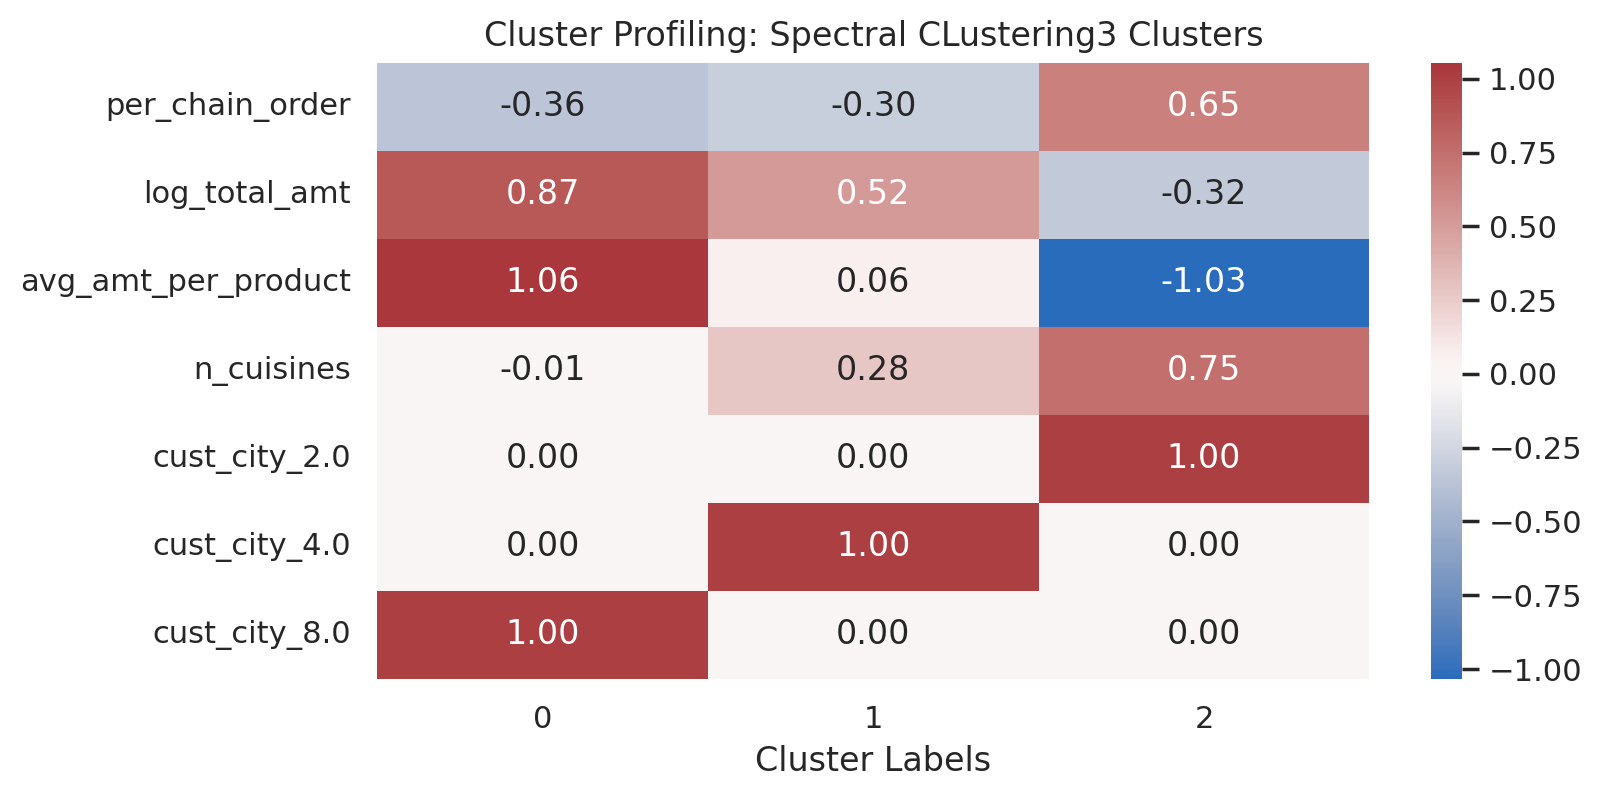

In [9]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df.groupby('labels').mean().T

sns.heatmap(hc_profile, center=0, annot=True, cmap="vlag", fmt=".2f", ax=ax)

ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling: Spectral Clustering {n_clusters} Clusters")
plt.show()

## Scoring

In [10]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df.drop(columns='labels'))  # get total sum of squares
ssw_labels = df.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

/tmp/ipykernel_23035/1605542028.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ssw_labels = df.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels


0.43395591023952307

## Profiling

In [11]:
df.head()

,per_chain_order,log_total_amt,avg_amt_per_product,n_cuisines,cust_city_2.0,cust_city_4.0,cust_city_8.0,labels
customer_id,,,,,,,,
1065389230692,-0.387685,-2.108552,-1.359722,-0.438966,1.0,0.0,0.0,2
533160600035,1.033887,1.120359,-0.438840,-1.125804,0.0,1.0,0.0,1
812241166844,-0.387685,-1.561839,-0.874395,-0.438966,1.0,0.0,0.0,2
317872695537,0.323101,-0.336569,-0.691827,0.247872,1.0,0.0,0.0,2
152011672230,1.033887,1.194030,2.002067,-0.438966,0.0,0.0,1.0,0


In [12]:
# Create dataframe with profiling columns
sd_after_profiling = pd.merge(
    df
    ,regulars[
        [col for col in regulars.columns if col.startswith('last_promo_')]
        +[col for col in regulars.columns if col.startswith('pay_method_')]
        # +[col for col in regulars.columns if col.startswith('cust_city_')]
        +[col for col in regulars.columns if col.startswith('cust_region_')]
        +[col for col in regulars.columns if col.startswith('age_bucket_')]
    ]
    ,left_index=True
    ,right_index=True
    ,how='left'
)

In [13]:
# Define the columns for each profile
profiling = {
    'Promotion': [col for col in sd_after_profiling.columns if col.startswith('last_promo_')]
    ,'Payment Method': [col for col in sd_after_profiling.columns if col.startswith('pay_method_')]
    # ,'City': [col for col in sd_after_profiling.columns if col.startswith('cust_city_')]
    ,'Region': [col for col in sd_after_profiling.columns if col.startswith('cust_region_')]
    ,'Age': [col for col in sd_after_profiling.columns if col.startswith('age_bucket_')]
}

In [14]:
for profile, col in profiling.items():
    cluster_profile = sd_after_profiling.groupby('labels')[col].mean()

    # Display cluster profiling
    print(f'Cluster Profiling Based on {profile}')
    display(cluster_profile)

Cluster Profiling Based on Promotion


,last_promo_DELIVERY,last_promo_DISCOUNT,last_promo_FREEBIE,last_promo_NO_PROMO
labels,,,,
0,0.142180,0.115324,0.139021,0.603476
1,0.104712,0.125654,0.108202,0.661431
2,0.161209,0.152393,0.132242,0.554156


Cluster Profiling Based on Payment Method


,pay_method_CARD,pay_method_CASH,pay_method_DIGI
labels,,,
0,0.733017,0.127962,0.139021
1,0.776614,0.116928,0.106457
2,0.682620,0.133501,0.183879


Cluster Profiling Based on Region


,cust_region_2360.0,cust_region_2400.0,cust_region_4140.0,cust_region_4660.0,cust_region_8370.0,cust_region_8550.0,cust_region_8670.0
labels,,,,,,,
0,0.000000,0.000000,0.00000,0.00000,0.025276,0.0,0.974724
1,0.000000,0.000000,0.04363,0.95637,0.000000,0.0,0.000000
2,0.836272,0.163728,0.00000,0.00000,0.000000,0.0,0.000000


Cluster Profiling Based on Age


,age_bucket_15-24,age_bucket_25-34,age_bucket_35-44,age_bucket_45-54,age_bucket_55-64,age_bucket_65+
labels,,,,,,
0,0.366509,0.483412,0.109005,0.036335,0.001580,0.00316
1,0.380454,0.500873,0.095986,0.015707,0.006981,0.00000
2,0.389169,0.497481,0.085642,0.018892,0.008816,0.00000


## Explaining the Clusters

In [15]:
# Load the scaler
scaler = joblib.load('std_scaler.pkl')

In [16]:
numeric = [
    'cust_age', 'n_vendor', 'n_product', 'n_chain', 'first_order',
    'last_order', 'american', 'asian', 'beverages', 'cafe',
    'chicken_dishes', 'chinese', 'desserts', 'healthy', 'indian', 'italian',
    'japanese', 'noodle_dishes', 'other', 'street_food_snacks', 'thai',
    'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0',
    'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9',
    'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17',
    'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'total_amt',
    'n_order', 'avg_amt_per_product', 'avg_amt_per_order',
    'avg_amt_per_vendor', 'days_cust', 'avg_days_to_order', 'days_due',
    'per_chain_order', 'n_days_week', 'n_times_day', 'n_cuisines',
    'log_n_vendor', 'log_n_product', 'log_n_chain', 'log_american',
    'log_asian', 'log_beverages', 'log_cafe', 'log_chicken_dishes',
    'log_chinese', 'log_desserts', 'log_healthy', 'log_indian',
    'log_italian', 'log_japanese', 'log_noodle_dishes', 'log_other',
    'log_street_food_snacks', 'log_thai', 'log_total_amt', 'log_n_order',
    'log_avg_amt_per_product', 'log_avg_amt_per_order',
    'log_avg_amt_per_vendor', 'log_n_days_week', 'log_n_times_day',
    'avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day'
]

In [17]:
# Revert the scaler
aux_unscaled_df = pd.DataFrame(scaler.inverse_transform(regulars[numeric]), columns=numeric, index=regulars.index)

In [18]:
indices = df.index

In [19]:
aux_unscaled_df = aux_unscaled_df.loc[indices]

In [20]:
# Transform the dataset with unscaled values for easier interpretation
for col in ['total_amt', 'n_cuisines', 'n_vendor', 'n_product']:
    df[col] = aux_unscaled_df[col]

In [21]:
df.groupby('labels').agg(['min', 'max', 'mean'])

per_chain_order                     log_total_amt                      \
                   min       max      mean           min       max      mean   
labels                                                                         
0            -1.809257  1.033887 -0.362103     -1.882944  2.920913  0.868443   
1            -1.809257  1.033887 -0.300161     -2.800132  2.679203  0.515216   
2            -1.809257  1.033887  0.653616     -2.537943  2.519026 -0.324632   

       avg_amt_per_product                     n_cuisines                  \
                       min       max      mean        min   max      mean   
labels                                                                      
0                -0.366247  2.714589  1.055219        1.0   7.0  2.627172   
1                -1.735508  2.344889  0.061107        1.0  10.0  3.045375   
2                -1.682766  0.146465 -1.032734        1.0  11.0  3.727960   

       cust_city_2.0           cust_city_4.0           cust_city_8.0       \
                 min  max mean           min  max mean           min  max   
labels                                                                      
0                0.0  0.0  0.0           0.0  0.0  0.0           1.0  1.0   
1                0.0  0.0  0.0           1.0  1.0  1.0           0.0  0.0   
2                1.0  1.0  1.0           0.0  0.0  0.0           0.0  0.0   

            total_amt                    n_vendor                 n_product  \
       mean       min     max       mean      min   max      mean       min   
labels                                                                        
0       1.0      5.96  324.60  76.515071      1.0  23.0  4.227488       1.0   
1       0.0      2.34  267.32  58.692496      1.0  15.0  4.118674       2.0   
2       0.0      3.12  235.03  32.040290      1.0  24.0  5.151134       2.0   

                        
         max      mean  
labels                  
0       35.0  7.360190  
1       39.0  8.514834  
2       61.0  9.249370

<>:8: SyntaxWarning: invalid escape sequence '\S'
<>:8: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipykernel_23035/1294623282.py:8: SyntaxWarning: invalid escape sequence '\S'
  ax.set_title(f"Cluster Profiling:\Spectral CLustering{n_clusters} Clusters")


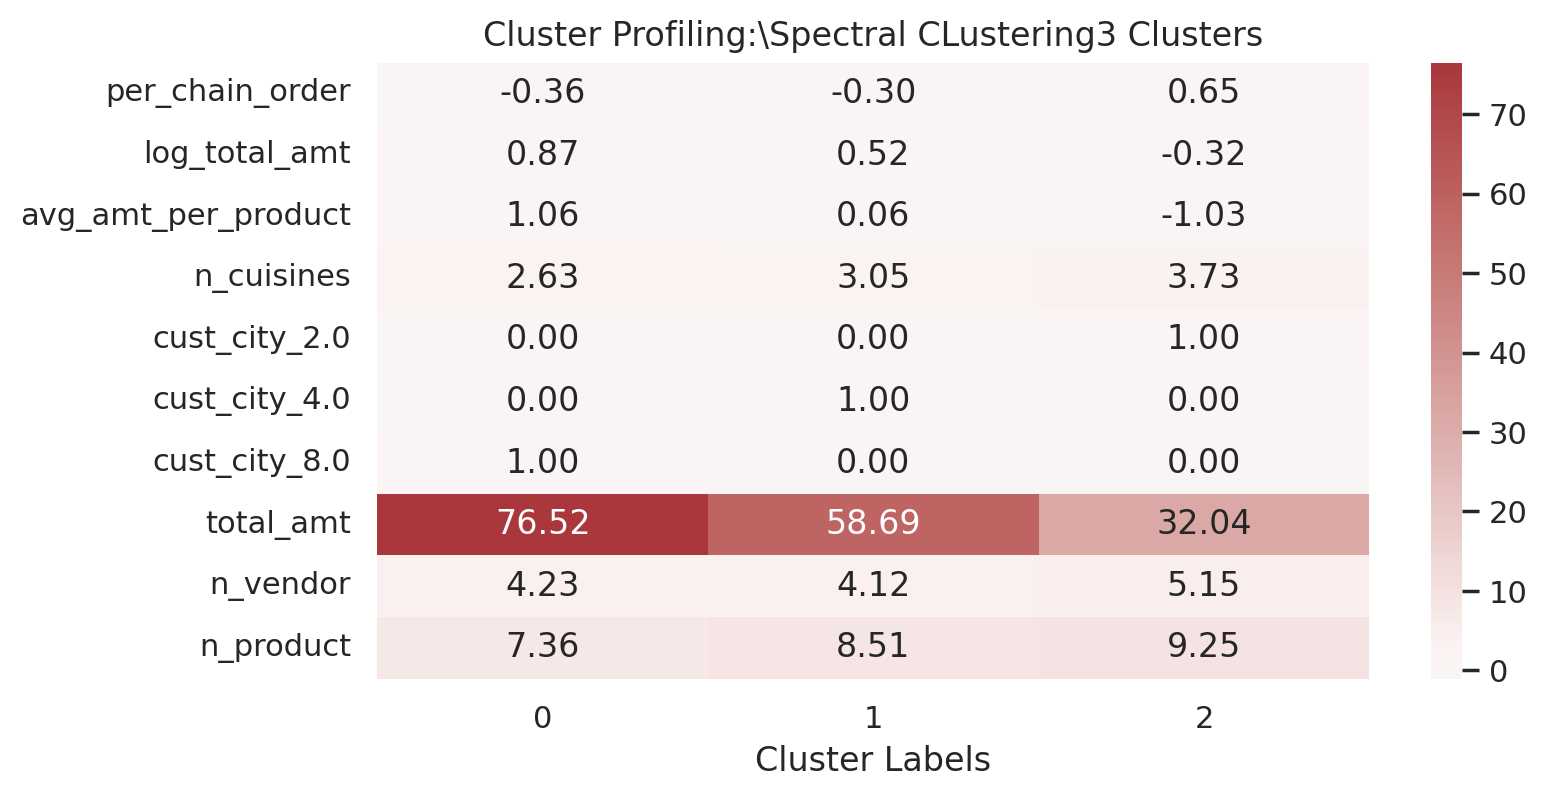

In [22]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df.groupby('labels').mean().T

sns.heatmap(hc_profile, center=0, annot=True, cmap="vlag", fmt=".2f", ax=ax)

ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling:\Spectral CLustering{n_clusters} Clusters")
plt.show()

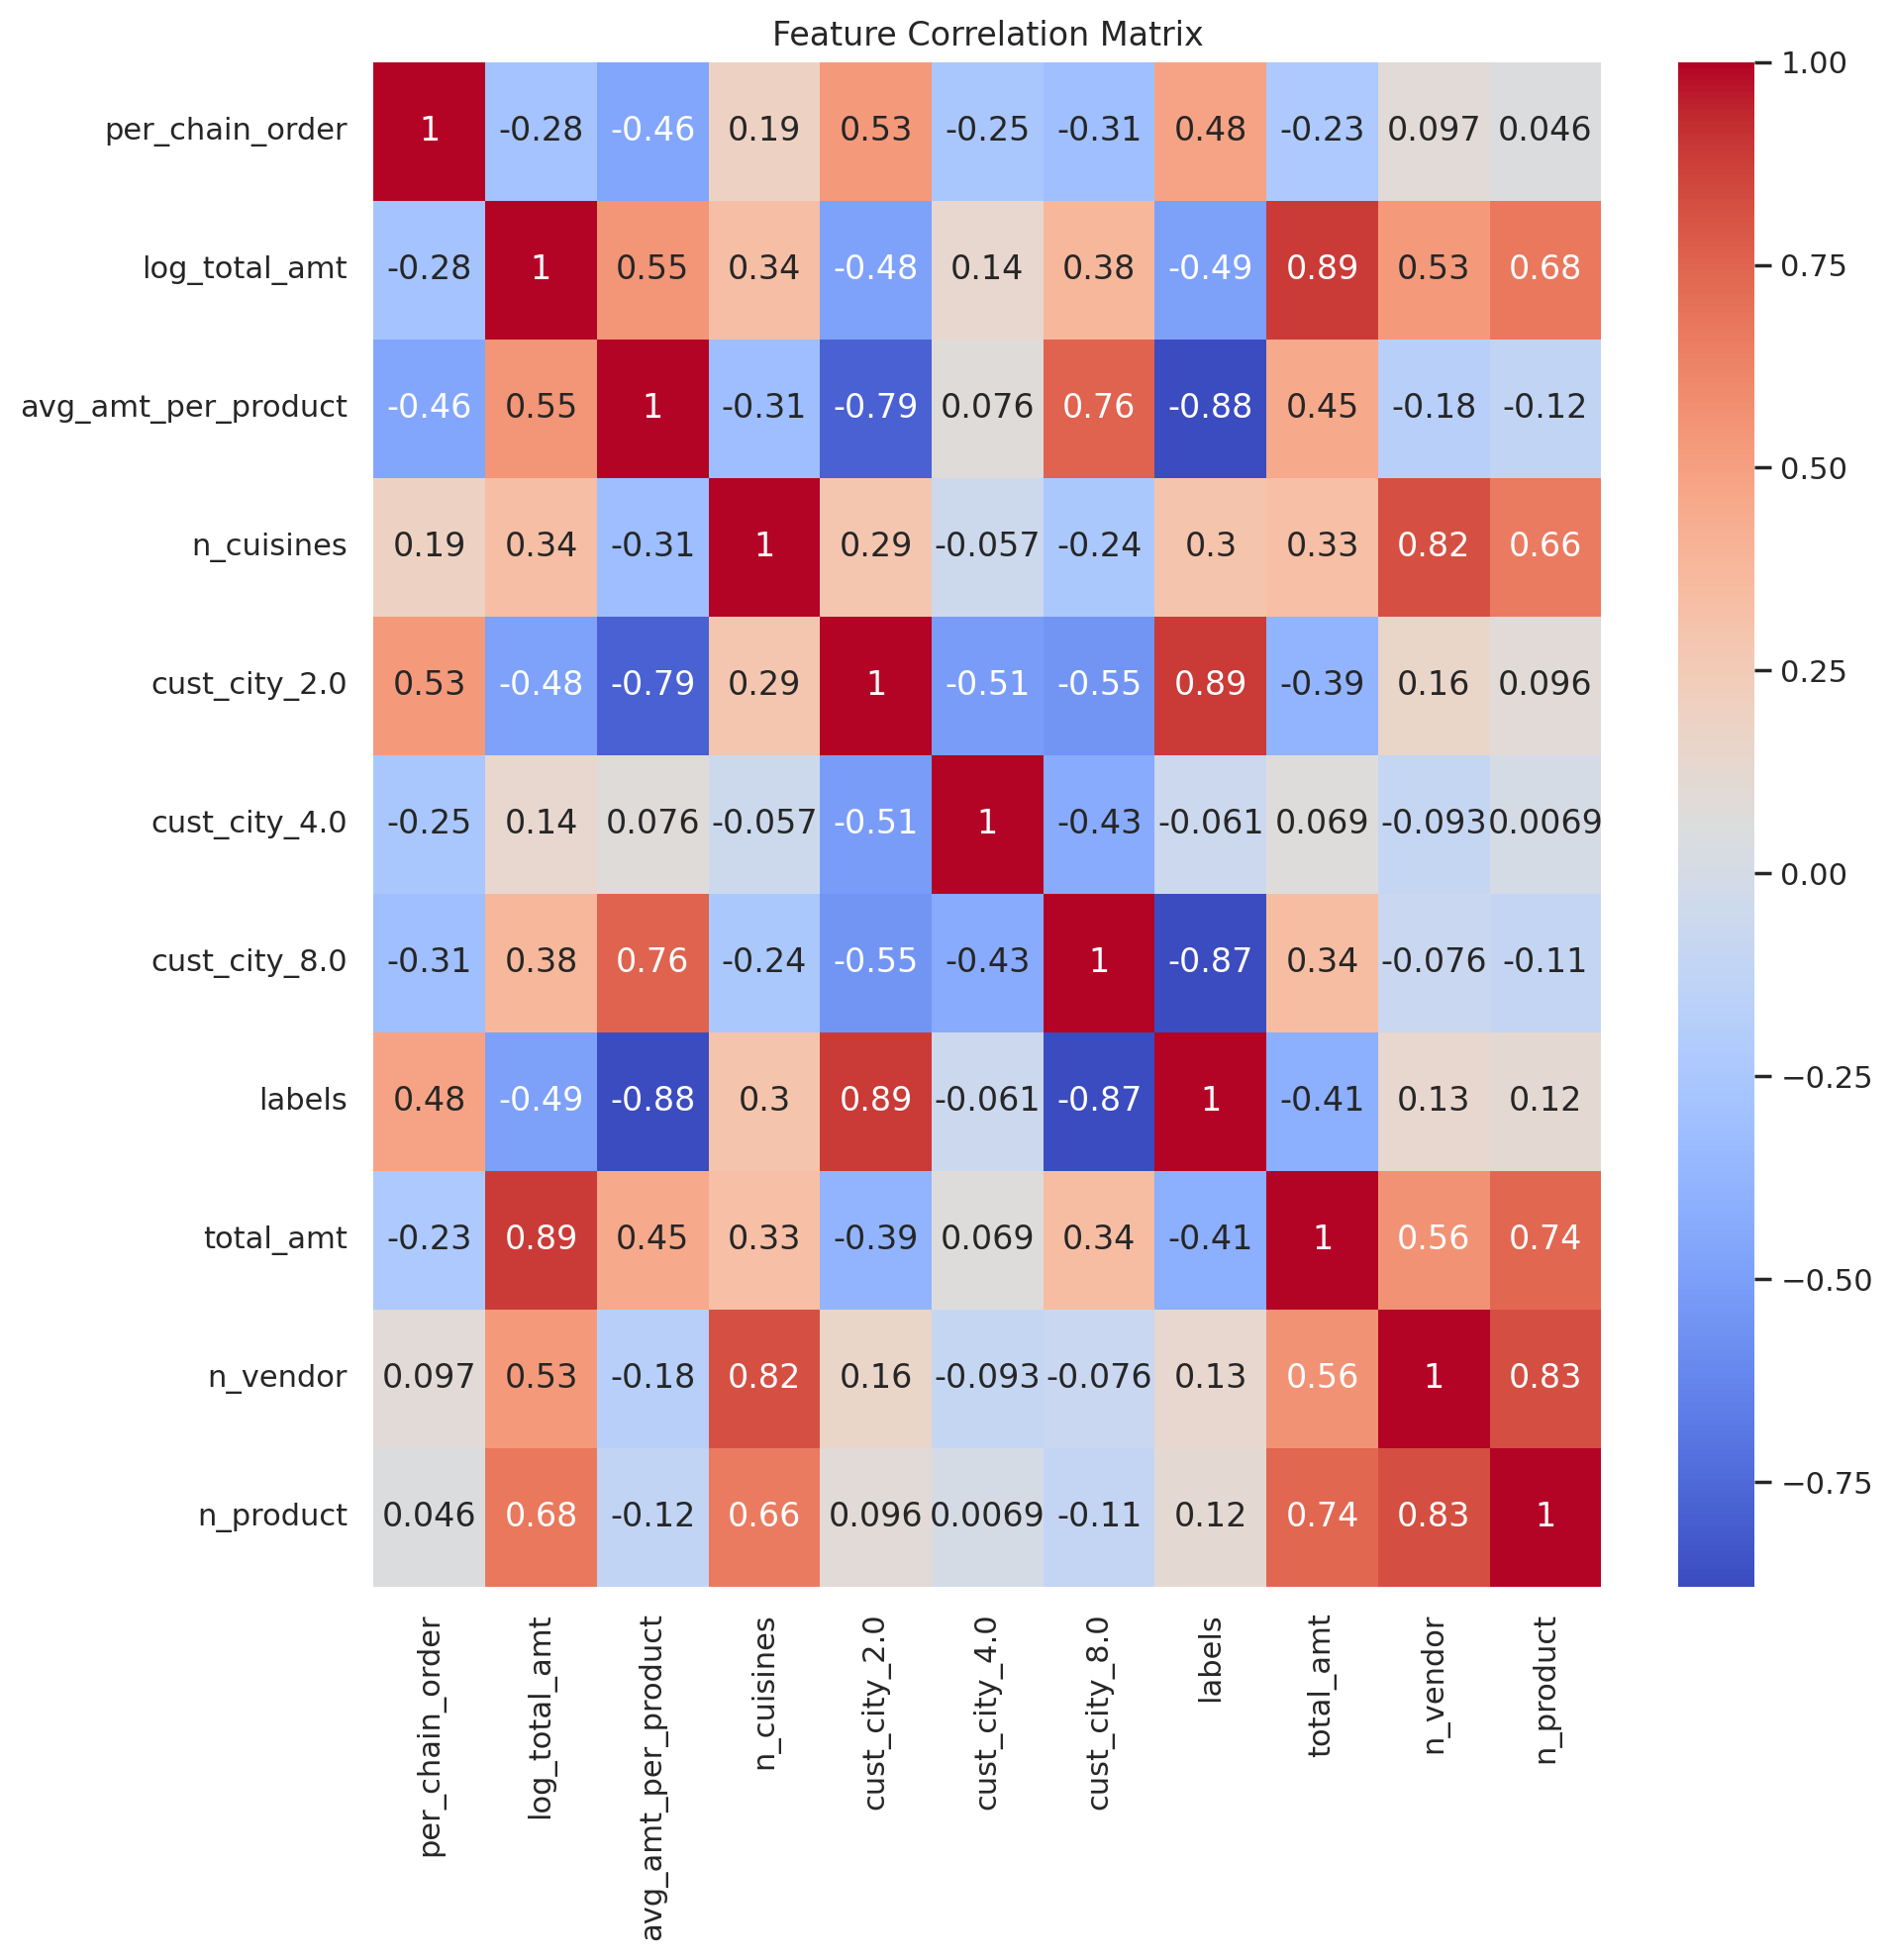

In [23]:
# Define the size of the heatmap
fig_size = (10, 10)  # Width, Height in inches

# Set the figure size
plt.figure(figsize=fig_size)
correlation_matrix = np.corrcoef(df.T)

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", xticklabels=df.columns, yticklabels=df.columns)
plt.title('Feature Correlation Matrix')
plt.show()